# PWC-$\beta$ time-integrated mean 2-norm of velocity gradient (sensitivity)

[GMM] Added .sample(n, seed) method.


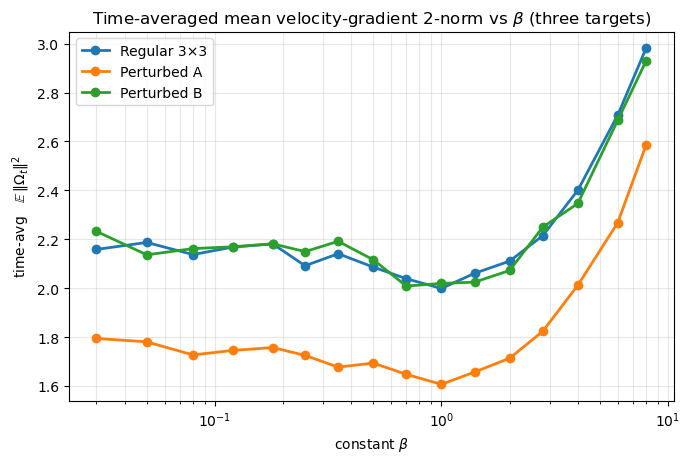

[saved] figs/three_models_avg_opnorm_vs_beta.png
[const best] Regular 3×3: β*≈1,  time-avg E||Ω_t||^2≈1.999
[const best] Perturbed A: β*≈1,  time-avg E||Ω_t||^2≈1.607
[const best] Perturbed B: β*≈0.7,  time-avg E||Ω_t||^2≈2.009


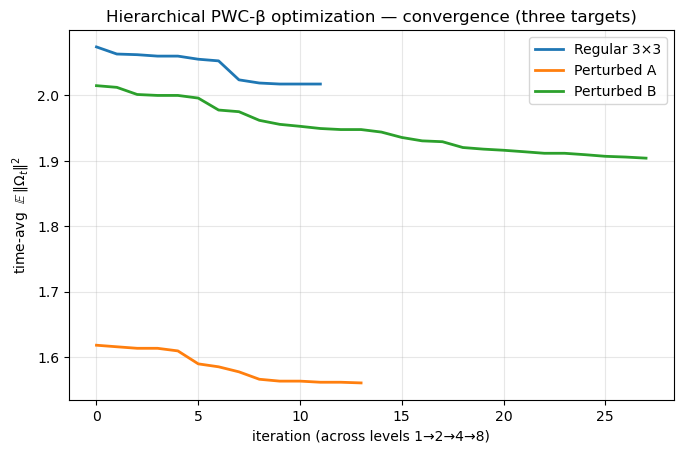

[saved] figs/meanOmega_convergence_hier_three_models.png


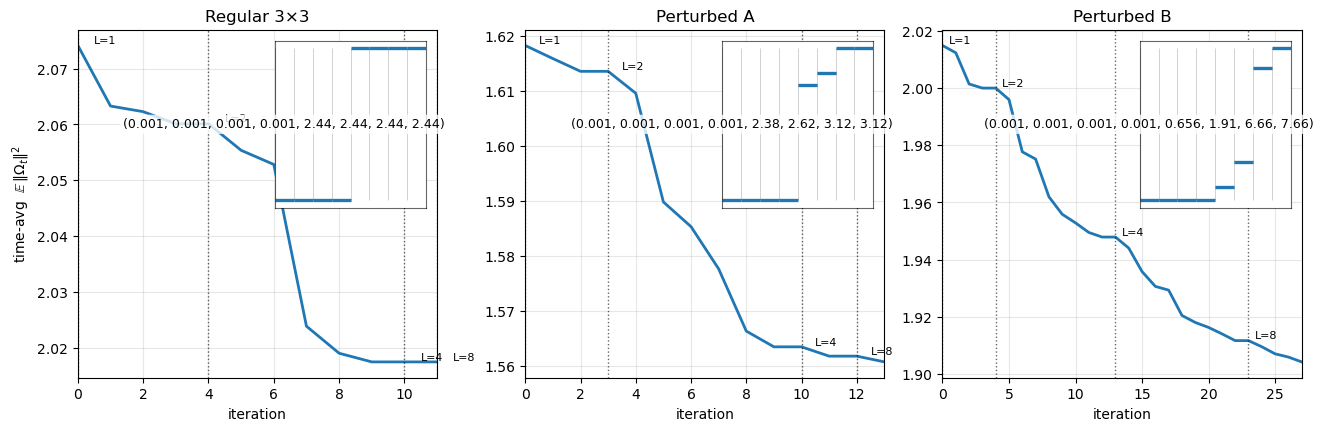

[saved] figs/meanOmega_convergence_hier_three_subplots_inset.png


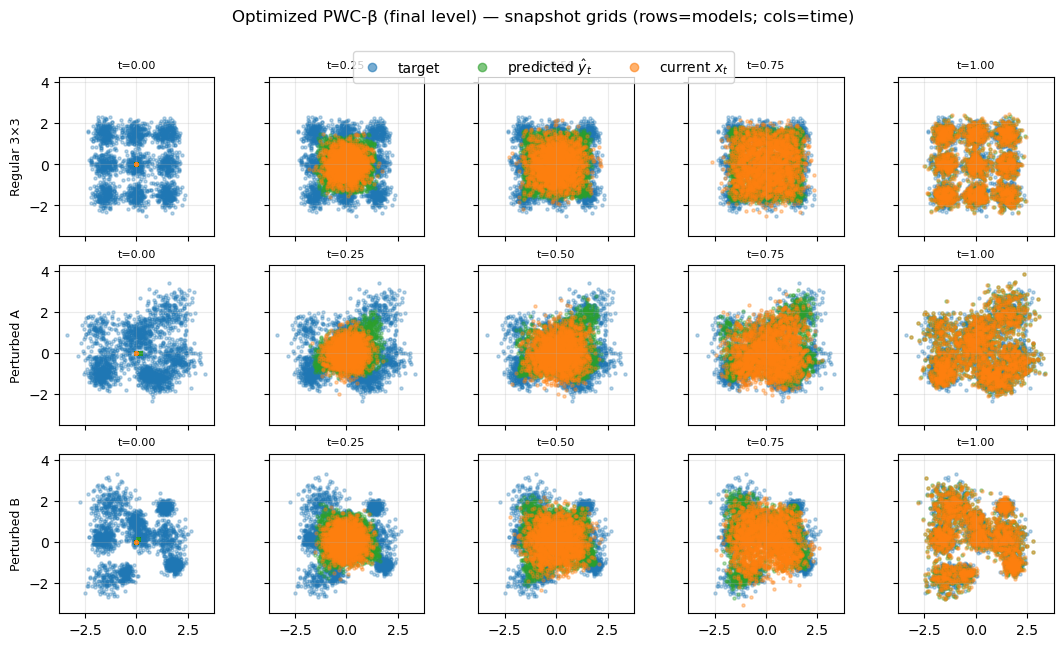

[saved] figs/three_models_PWC_snapshot_grid_optimized.png


In [1]:
import numpy as np, math, os, time
import matplotlib.pyplot as plt
from ada_api_clean import *  # uses yhat_oracle_gmm, GMM, sample_gmm, regular, pertA, pertB

os.makedirs("figs", exist_ok=True)

from mpl_toolkits.axes_grid1.inset_locator import inset_axes

# ============================================================
#   Hierarchical PWC-β optimization (1→2→4→8) for each model
#   Snapshot grids using final optimized (L=8) schedules (3×5)
#
# Prereqs in the notebook:
#   - GMM(MU, SIG, PI), sample_gmm(gmm, M, rng)
#   - yhat_oracle_gmm(X, t, sched, gmm)
#   - alpha_K_gamma_from_schedule(sched, t)
#   - BetaSchedulePWC with .constant(...) and PWC constructor
# ============================================================

import numpy as np, math, os
import matplotlib.pyplot as plt

os.makedirs("figs", exist_ok=True)


# ---------------------------- model builders ----------------------------
def build_regular_grid_gmm(a=1.5, sigma=0.3):
    xs = np.array([-a, 0.0, a], float)
    MU  = np.array([[xi, yj] for yj in xs for xi in xs], float)  # (9,2)
    SIG = np.full(9, float(sigma))
    PI  = np.ones(9, float)/9.0
    return GMM(MU, SIG, PI)

def build_perturbed_gmm(seed, a=1.5, base_sigma=0.3,
                        jitter_frac=1/3, sig_scale=(0.5, 2.0),
                        weight_range=(0.5, 1.5)):
    rng = np.random.default_rng(int(seed))
    xs = np.array([-a, 0.0, a], float)
    centers = np.array([[xi, yj] for yj in xs for xi in xs], float)  # (9,2)
    jitter_max = a * float(jitter_frac)
    MU  = centers + rng.uniform(-jitter_max, jitter_max, size=centers.shape)
    SIG = base_sigma * rng.uniform(sig_scale[0], sig_scale[1], size=9)  # per-comp σ_k > 0
    w   = rng.uniform(weight_range[0], weight_range[1], size=9)
    PI  = w / np.sum(w)
    return GMM(MU, SIG, PI)

# ---------------------------- Jacobian & schedule utilities ----------------------------
def jac_yhat_wrt_X_fd(X, t, sched, gmm, eps_m=None):
    """
    Central FD Jacobian of ŷ(t;X) wrt X via perturbing m=αX:
        ∂ŷ/∂X ≈ α [ŷ(m+ε e_i) - ŷ(m-ε e_i)] / (2ε) (col i).
    """
    X = np.asarray(X, float)
    Q, d = X.shape
    alpha, _, gamma = alpha_K_gamma_from_schedule(sched, float(t))
    alpha = float(alpha)
    if not np.isfinite(alpha) or abs(alpha) < 1e-12:
        raise RuntimeError(f"alpha(t) ill-conditioned at t={t}: {alpha}")
    if eps_m is None:
        eps_m = 1e-3 * max(float(gamma), 1e-2)

    J  = np.zeros((Q, d, d), float)
    dX = eps_m / alpha
    for i in range(d):
        Xp = X.copy(); Xp[:, i] += dX
        Xm = X.copy(); Xm[:, i] -= dX
        Yp = yhat_oracle_gmm(Xp, float(t), sched, gmm)
        Ym = yhat_oracle_gmm(Xm, float(t), sched, gmm)
        col = (Yp - Ym) / (2.0 * eps_m)
        J[:, :, i] = alpha * col
    return J

def make_pwc_schedule(splits, betas):
    splits = np.asarray(splits, float)
    betas  = np.asarray(betas, float)
    assert len(splits) == len(betas) + 1, "PWC requires len(splits)=len(betas)+1"
    assert np.all(np.diff(splits) > 0), "splits must be strictly increasing"
    tried = []
    for ctor in (
        lambda: BetaSchedulePWC.PWC(splits=splits, betas=betas),
        lambda: BetaSchedulePWC(betas=betas, splits=splits),
        lambda: BetaSchedulePWC.piecewise_constant(splits=splits, betas=betas),
    ):
        try:
            sched = ctor()
            # quick interior health probes
            for tp in (0.2, 0.5, 0.8):
                a, K, g = alpha_K_gamma_from_schedule(sched, float(tp))
                if not (np.isfinite(a) and np.isfinite(K) and K > 0 and np.isfinite(g) and g > 0):
                    raise RuntimeError("health probe failed")
            return sched
        except Exception as e:
            tried.append(repr(e))
    raise RuntimeError("Could not build PWC schedule.\n" + "\n".join(tried))

# ---------------------------- objective: time-avg mean ||Ω_t||_2 ----------------------------
def mean_Omega_opnorm(
    sched, gmm, *, M=1200, T=600, seed=123, N_eval=16, Q_stat=300, t_low=0.01, eps_m=None
):
    """
    Simulate once with midpoint EM (X(0)=0). At N_eval interior steps t=(n+0.5)/T:
      - fixed subset of Q_stat particles (CRN)
      - J=∂ŷ/∂x via central diff in m=αX
      - Ω = b^- J − a^- I; op-norm via eigvalsh => max|λ|
      - average over particles, then over times
    Returns scalar: E_t [ E_particles ||Ω_t||_2 ].
    """
    rng = np.random.default_rng(seed)
    dt = 1.0 / T
    d  = gmm.d
    X  = np.zeros((M, d), float)  # X(0)=0

    idx = np.linspace(0, T-1, int(min(max(1, N_eval), T))).round().astype(int)
    idx = np.unique(np.clip(idx, 0, T-1))
    t_eval = (idx + 0.5)/T
    sub_idx = rng.choice(M, size=int(min(Q_stat, M)), replace=False)

    means_per_time = np.empty(t_eval.size, float)
    idx_set = set(idx.tolist()); k = 0

    for n in range(T):
        t_mid = (n + 0.5)/T
        t_eff = min(max(t_mid, float(t_low)), 1.0 - float(t_low))

        yhat = yhat_oracle_gmm(X, float(t_eff), sched, gmm)
        a_m  = float(sched.a_minus(float(t_eff)))
        b_m  = float(sched.b_minus(float(t_eff)))
        u    = b_m * yhat - a_m * X

        if n in idx_set:
            X_sub = X[sub_idx, :]
            J = jac_yhat_wrt_X_fd(X_sub, float(t_eff), sched, gmm, eps_m=eps_m)
            I = np.eye(d)[None,:,:]
            Omega = b_m * J - a_m * I
            evals = np.linalg.eigvalsh(Omega)        # (Q,d)
            opn   = np.max(np.abs(evals), axis=1)    # ||Ω||_2 per particle
            means_per_time[k] = float(np.mean(opn)); k += 1

        dW = rng.normal(size=X.shape) * math.sqrt(dt)
        X  = X + u*dt + dW

    return float(np.mean(means_per_time[:k])) if k > 0 else np.inf

def objective_for_betas(betas, splits, gmm, *, M, T, seed, N_eval, Q_stat, t_low, eps_m):
    try:
        sched = make_pwc_schedule(splits, betas)
        for tp in (0.1, 0.3, 0.7, 0.9):
            a, K, g = alpha_K_gamma_from_schedule(sched, float(tp))
            if not (np.isfinite(a) and np.isfinite(K) and K>0 and np.isfinite(g) and g>0):
                return np.inf
        return mean_Omega_opnorm(sched, gmm, M=M, T=T, seed=seed,
                                 N_eval=N_eval, Q_stat=Q_stat, t_low=t_low, eps_m=eps_m)
    except Exception:
        return np.inf

def coord_descent_meanO(
    betas0, splits, gmm, *, M, T, seed, N_eval, Q_stat, t_low,
    eps_m=None, step0=1.0, step_min=0.02, improve_tol=1e-3, max_sweeps=8,
    BETA_MIN=1e-3, BETA_MAX=10.0, record=None
):
    b = np.asarray(betas0, float).copy()
    K = len(b)
    fbest = objective_for_betas(b, splits, gmm, M=M, T=T, seed=seed,
                                N_eval=N_eval, Q_stat=Q_stat, t_low=t_low, eps_m=eps_m)
    if record is not None: record.append(fbest)
    step = float(step0)
    for sweep in range(max_sweeps):
        improved = False
        for k in range(K):
            for sgn in (+1, -1):
                cand = b.copy()
                cand[k] = np.clip(cand[k] + sgn*step, BETA_MIN, BETA_MAX)
                f = objective_for_betas(cand, splits, gmm, M=M, T=T, seed=seed,
                                        N_eval=N_eval, Q_stat=Q_stat, t_low=t_low, eps_m=eps_m)
                if f + improve_tol < fbest:
                    b, fbest = cand, f
                    improved = True
                    if record is not None: record.append(fbest)
        if not improved:
            step *= 0.5
            if step < step_min:
                break
    return b, float(fbest)

# ---------------------------- constant-β sweep helper ----------------------------
def time_avg_mean_opnorm_for_model(gmm_model, beta_grid, M=1400, T=900, seed=1234,
                                   N_eval=24, Q_stat=350):
    vals = []
    for b in beta_grid:
        sched = BetaSchedulePWC.constant(float(b))
        _ = alpha_K_gamma_from_schedule(sched, 0.5)
        summ = omega_stats_vs_time(
            sched, gmm_model, M=M, T=T, seed=seed + int(31*b),
            N_eval=N_eval, Q_stat=Q_stat, eps_m=None
        )
        vals.append(float(np.mean(summ["mean_op"])))
    return np.asarray(beta_grid, float), np.asarray(vals, float)

def argmin_beta(beta, vals):
    j = int(np.nanargmin(vals))
    return float(beta[j]), float(vals[j])

# ---------------------------- generic snapshot simulator for any schedule ----------------------------
def simulate_snapshots_for_sched(sched, gmm, M=1500, T=600, seed=1234, N_cols=5, t_floor=0.01):
    rng  = np.random.default_rng(seed)
    dt   = 1.0 / T
    d    = gmm.d
    X    = np.zeros((M, d), float)

    idx  = np.linspace(0, T-1, N_cols).round().astype(int)
    ptr  = 0
    times = []; snaps_X = []; snaps_Yh = []

    for n in range(T):
        t_mid = (n + 0.5) / T
        t_eff = min(max(t_mid, float(t_floor)), 1.0 - float(t_floor))
        yhat  = yhat_oracle_gmm(X, float(t_eff), sched, gmm)
        a_m   = float(sched.a_minus(float(t_eff)))
        b_m   = float(sched.b_minus(float(t_eff)))
        u     = b_m * yhat - a_m * X

        if ptr < len(idx) and n == idx[ptr]:
            times.append(t_mid)
            snaps_X.append(X.copy())
            snaps_Yh.append(yhat.copy())
            ptr += 1

        dW = rng.normal(size=X.shape) * math.sqrt(dt)
        X  = X + u*dt + dW

    return np.array(times, float), snaps_X, snaps_Yh

# ---------- Ω_t + radial sensitivities vs time ----------
def omega_stats_vs_time(sched, gmm, M=1200, T=800, seed=1, N_eval=24, Q_stat=400, eps_m=None):
    """
    Simulate once with midpoint EM, starting from X(0)=0.
    At N_eval midpoints spanning the *entire interior* (0,1), compute:
      • matrix stats of Ω_t = b^-·(∂ŷ/∂x) − a^-·I   on a random subset of Q_stat particles
      • radial (collinear) sensitivities means:
          \hatΩ_t^{∥} = v^T (∂ŷ/∂x) v,   v = x/||x||
          \tildeΩ_t^{∥} = (b^-/a^-) · \hatΩ_t^{∥}
          Ω_t^{∥} = b^-·\hatΩ_t^{∥} − a^-
    Returns dict with time grid and per-time means.
    """
    rng = np.random.default_rng(seed)
    dt = 1.0 / T
    d  = gmm.d
    X  = np.zeros((M, d), float)  # ENFORCE x(0)=0

    # choose N_eval evenly-spaced *interior* midpoints across n=0..T-1
    N_eval_eff = int(min(max(1, N_eval), T))
    t_idx = np.unique(np.linspace(0, T-1, N_eval_eff).round().astype(int))
    t_idx = np.clip(t_idx, 0, T-1)
    t_eval = (t_idx + 0.5) / T

    Q_stat = int(min(Q_stat, M))
    sub_idx = rng.choice(M, size=Q_stat, replace=False)

    mean_op   = np.empty(t_eval.size, float)
    mean_tr   = np.empty_like(mean_op)
    mean_lmax = np.empty_like(mean_op)
    mean_lmin = np.empty_like(mean_op)

    mean_Omega_par      = np.empty_like(mean_op)  # Ω_t^{∥}
    mean_Omegahat_par   = np.empty_like(mean_op)  # \hatΩ_t^{∥}
    mean_Omegatilde_par = np.empty_like(mean_op)  # \tildeΩ_t^{∥}

    # speed up membership checks
    t_idx_set = set(t_idx.tolist())
    k = 0
    for n in range(T):
        t = (n + 0.5) / T
        yhat = yhat_oracle_gmm(X, float(t), sched, gmm)
        a_m  = float(sched.a_minus(float(t)))
        b_m  = float(sched.b_minus(float(t)))
        u    = b_m * yhat - a_m * X

        if n in t_idx_set:
            X_sub = X[sub_idx, :]
            # Jacobian of predicted map and Ω_t
            J = jac_yhat_wrt_X_fd(X_sub, float(t), sched, gmm, eps_m=eps_m)   # (Q,d,d)
            I = np.eye(d)[None, :, :]
            Omega = b_m * J - a_m * I                                        # (Q,d,d)

            # matrix stats (Ω is ~symmetric numerically)
            evals = np.linalg.eigvalsh(Omega)        # (Q,d)
            opnorm = np.max(np.abs(evals), axis=1)   # ||Ω||_2
            mean_op[k]   = float(np.mean(opnorm))
            mean_tr[k]   = float(np.mean(np.sum(evals, axis=1)))
            mean_lmax[k] = float(np.mean(evals[:, -1]))
            mean_lmin[k] = float(np.mean(evals[:,  0]))

            # radial (collinear) sensitivities
            v = X_sub / (np.linalg.norm(X_sub, axis=1, keepdims=True) + 1e-12)  # (Q,d)
            # \hatΩ_t^{∥} = v^T J v
            Jv = np.einsum("qij,qj->qi", J, v)               # (Q,d)
            hat_par = np.einsum("qi,qi->q", Jv, v)           # (Q,)
            # \tildeΩ_t^{∥} = (b^-/a^-) · \hatΩ_t^{∥}
            if abs(a_m) > 1e-12:
                tilde_par = (b_m / a_m) * hat_par
            else:
                tilde_par = np.full_like(hat_par, np.nan)
            # Ω_t^{∥} = b^-·\hatΩ_t^{∥} − a^-
            Omega_par = b_m * hat_par - a_m

            mean_Omegahat_par[k]   = float(np.nanmean(hat_par))
            mean_Omegatilde_par[k] = float(np.nanmean(tilde_par))
            mean_Omega_par[k]      = float(np.nanmean(Omega_par))
            k += 1

        dW = rng.normal(size=X.shape) * math.sqrt(dt)
        X  = X + u*dt + dW

    return {
        "t_eval": t_eval,
        "mean_op": mean_op, "mean_tr": mean_tr,
        "mean_lmax": mean_lmax, "mean_lmin": mean_lmin,
        "mean_Omega_par": mean_Omega_par,
        "mean_Omegahat_par": mean_Omegahat_par,
        "mean_Omegatilde_par": mean_Omegatilde_par,
    }


# ============================ build three models ============================
models = [
    ("Regular 3×3", regular),
    ("Perturbed A",  pertA),
    ("Perturbed B",  pertB),
]

# ============================ (A) constant-β sweep ============================
beta_grid = np.array([0.03, 0.05, 0.08, 0.12, 0.18, 0.25, 0.35, 0.5, 0.7, 1.0,
                      1.4, 2.0, 2.8, 4.0, 6.0, 8.0], float)

M_sweep, T_sweep = 2000, 500
N_eval, Q_stat   = 200, 350
seed_sweep_base  = 20241011

curves = {}
for i, (name, gmm_model) in enumerate(models):
    b, v = time_avg_mean_opnorm_for_model(
        gmm_model, beta_grid, M=M_sweep, T=T_sweep,
        seed=seed_sweep_base + 100*i, N_eval=N_eval, Q_stat=Q_stat
    )
    curves[name] = {"beta": b, "avg_op": v, "gmm": gmm_model}

plt.figure(figsize=(7.8, 4.8))
colors = plt.rcParams["axes.prop_cycle"].by_key()["color"]
for i, (name, info) in enumerate(curves.items()):
    plt.plot(info["beta"], info["avg_op"], marker="o", lw=2.0, color=colors[i%len(colors)], label=name)
plt.xscale("log")
plt.xlabel(r"constant $\beta$")
plt.ylabel(r"time-avg  $\ \mathbb{E}\,\|\Omega_t\|^2$")
plt.title(r"Time-averaged mean velocity-gradient 2-norm vs $\beta$ (three targets)")
plt.grid(True, which="both", alpha=0.3)
plt.legend(frameon=True)
fname_curve_const = "figs/three_models_avg_opnorm_vs_beta.png"
plt.savefig(fname_curve_const, dpi=300, bbox_inches="tight"); plt.show()
print("[saved]", fname_curve_const)

# pick best constant-β per model
best_const = {}
for i, (name, info) in enumerate(curves.items()):
    b_opt, v_opt = argmin_beta(info["beta"], info["avg_op"])
    best_const[name] = {"beta": b_opt, "avg": v_opt, "gmm": info["gmm"]}
    print(f"[const best] {name}: β*≈{b_opt:.3g},  time-avg E||Ω_t||^2≈{v_opt:.4g}")
    

# ============================ (B) hierarchical PWC-β optimization (per model) ============================
# runtime/accuracy knobs for optimization
M_eval  = 2000
T_eval  = 500
Q_stat  = 300
N_eval  = 200
seed_sim_base = 20241012
t_low   = 0.01
eps_m   = None
BETA_MIN, BETA_MAX = 1e-3, 10.0
beta_init = 1.0
levels = [1, 2, 4, 8]

opt_records = {}     # name -> dict(best_at, traj, level_marks)
for m_idx, (name, gmm_model) in enumerate(models):
    traj, level_marks = [], []
    best_at = {}
    b_parent = np.array([beta_init], float)
    splits_parent = np.array([0.0, 1.0], float)

    for L in levels:
        if L == 1:
            splitsL = splits_parent.copy()
            b_init  = b_parent.copy()
        else:
            splitsL = np.linspace(0.0, 1.0, L+1)
            b_init = np.empty(L, float)
            for i in range(L):
                t_mid = 0.5*(splitsL[i] + splitsL[i+1])
                j = max(0, min(len(b_parent)-1, np.searchsorted(np.linspace(0,1,len(b_parent)+1), t_mid, 'right')-1))
                b_init[i] = float(b_parent[j])

        start_idx = len(traj)
        b_star, f_star = coord_descent_meanO(
            b_init, splitsL, gmm_model,
            M=M_eval, T=T_eval, seed=seed_sim_base + 123*m_idx,
            N_eval=N_eval, Q_stat=Q_stat, t_low=t_low, eps_m=eps_m,
            step0=1.0, step_min=0.02, improve_tol=1e-3, max_sweeps=8,
            BETA_MIN=BETA_MIN, BETA_MAX=BETA_MAX,
            record=traj
        )
        level_marks.append(start_idx)
        best_at[L] = dict(betas=b_star.copy(), f=float(f_star), splits=splitsL.copy())
        # prepare for next level
        b_parent, splits_parent = b_star.copy(), splitsL.copy()

    opt_records[name] = dict(best_at=best_at, traj=traj, level_marks=level_marks)

# plot convergence curves of all 3 models on one figure
plt.figure(figsize=(7.8, 4.8))
for i, (name, rec) in enumerate(opt_records.items()):
    plt.plot(np.arange(len(rec["traj"])), rec["traj"], lw=2.0, label=name)
plt.xlabel("iteration (across levels 1→2→4→8)")
plt.ylabel(r"time-avg $\ \mathbb{E}\,\|\Omega_t\|^2$")
plt.title("Hierarchical PWC-β optimization — convergence (three targets)")
plt.grid(True, alpha=0.3)
plt.legend(frameon=True)
fname_conv = "figs/meanOmega_convergence_hier_three_models.png"
plt.savefig(fname_conv, dpi=300, bbox_inches="tight"); plt.show()
print("[saved]", fname_conv)

# ---- fallbacks if helpers not in scope ----
try:
    simulate_snapshots_for_sched
except NameError:
    def simulate_snapshots_for_sched(sched, gmm, M=1500, T=600, seed=1234, N_cols=5, t_floor=0.01):
        rng  = np.random.default_rng(seed)
        dt   = 1.0 / T
        d    = gmm.d
        X    = np.zeros((M, d), float)
        idx  = np.linspace(0, T-1, N_cols).round().astype(int)
        ptr  = 0
        times = []; snaps_X = []; snaps_Yh = []
        for n in range(T):
            t_mid = (n + 0.5) / T
            t_eff = min(max(t_mid, float(t_floor)), 1.0 - float(t_floor))
            yhat  = yhat_oracle_gmm(X, float(t_eff), sched, gmm)
            a_m   = float(sched.a_minus(float(t_eff)))
            b_m   = float(sched.b_minus(float(t_eff)))
            u     = b_m * yhat - a_m * X
            if ptr < len(idx) and n == idx[ptr]:
                times.append(t_mid); snaps_X.append(X.copy()); snaps_Yh.append(yhat.copy()); ptr += 1
            dW = rng.normal(size=X.shape) * math.sqrt(dt)
            X  = X + u*dt + dW
        return np.array(times, float), snaps_X, snaps_Yh

try:
    make_pwc_schedule
except NameError:
    def make_pwc_schedule(splits, betas):
        splits = np.asarray(splits, float)
        betas  = np.asarray(betas, float)
        for ctor in (
            lambda: BetaSchedulePWC.PWC(splits=splits, betas=betas),
            lambda: BetaSchedulePWC(betas=betas, splits=splits),
            lambda: BetaSchedulePWC.piecewise_constant(splits=splits, betas=betas),
        ):
            try:
                sched = ctor()
                _ = alpha_K_gamma_from_schedule(sched, 0.5)
                return sched
            except Exception:
                pass
        raise RuntimeError("Could not build PWC schedule from provided API.")

if "opt_records" not in globals():
    raise RuntimeError("opt_records not found; please run the optimization cell first.")
if "models" not in globals():
    raise RuntimeError("models not found; please run the model-building cell first.")

# ============================================================
# (C) Convergence: 3 subplots, each auto-ranged + β(t) inset
# ============================================================

fig, axs = plt.subplots(1, 3, figsize=(13.0, 4.2), sharey=False, constrained_layout=True)
if not isinstance(axs, np.ndarray):
    axs = np.array([axs])

for ax, (name, gmm_model) in zip(axs, models):
    rec = opt_records[name]
    traj = np.asarray(rec["traj"], float)
    it   = np.arange(len(traj))
    ax.plot(it, traj, lw=2.0)
    # individual x/y ranges (pad 5%)
    if len(traj) > 0:
        ax.set_xlim(0, len(traj)-1)
        ymin, ymax = float(np.min(traj)), float(np.max(traj))
        pad = 0.05 * (ymax - ymin + 1e-12)
        ax.set_ylim(ymin - pad, ymax + pad)
    # level markers
    for m, L in zip(rec["level_marks"], [1,2,4,8]):
        if m < len(traj):
            ax.axvline(m, color="k", lw=1, ls=":", alpha=0.6)
            ax.text(m + 0.5, traj[m], f"L={L}", fontsize=8, va="bottom", ha="left")
    ax.grid(True, alpha=0.3)
    ax.set_title(name)
    ax.set_xlabel("iteration")
axs[0].set_ylabel(r"time-avg $\ \mathbb{E}\,\|\Omega_t\|^2$")

# add an inset with final optimal β(t) schedule for each subplot
for ax, (name, _) in zip(axs, models):
    rec = opt_records[name]
    # pick L=8 if present, else the largest available
    L_keys = sorted(rec["best_at"].keys())
    L_fin  = 8 if 8 in L_keys else L_keys[-1]
    item   = rec["best_at"][L_fin]
    splits, betas, fstar = item["splits"], item["betas"], item["f"]
    # inset axis
    # --- inset with final β(t), drawn at TOP-LEFT and annotated with β numbers ---

    axins = inset_axes(ax, width="42%", height="48%", loc="upper right", borderpad=0.8)

    # draw β(t) steps
    spl = item["splits"]; bet = item["betas"]
    bmin, bmax = float(np.min(bet)), float(np.max(bet))
    for i in range(len(bet)):
        axins.hlines(bet[i], spl[i], spl[i+1], colors="C0", lw=2.4)
        axins.vlines(spl[i], bmin, bmax, color="k", lw=0.5, alpha=0.25)
    axins.vlines(spl[-1], bmin, bmax, color="k", lw=0.5, alpha=0.25)

    # tidy: no ticks/labels/title
    axins.set_xlim(0, 1)
    axins.set_ylim(bmin - 0.05*(bmax-bmin+1e-12), bmax + 0.05*(bmax-bmin+1e-12))
    axins.set_xticks([]); axins.set_yticks([])
    axins.set_xlabel(""); axins.set_ylabel("")
    for spine in axins.spines.values():
        spine.set_alpha(0.6)

    # centered β-values (ordered)
    beta_str = "(" + ", ".join(f"{x:.3g}" for x in bet) + ")"
    axins.text(0.06, 0.5, beta_str,
               transform=axins.transAxes, ha="center", va="center",
               fontsize=9, bbox=dict(boxstyle="round,pad=0.25", fc="white", ec="none", alpha=0.8))

fname_conv3 = "figs/meanOmega_convergence_hier_three_subplots_inset.png"
fig.savefig(fname_conv3, dpi=300, bbox_inches="tight"); plt.show()
print("[saved]", fname_conv3)

# ============================================================
# (D) Snapshot grids at final optimized schedules
#     • Remove schedule text from rows; keep only model name.
#     • Order: exact → predicted → current
# ============================================================

M_snap, T_snap, seed_snap = 2000, 500, 20241013
N_cols = 5
green = "#2ca02c"

# collect snapshots & common limits
snap_results = []
XY_all = []
for i, (name, gmm_model) in enumerate(models):
    rec   = opt_records[name]
    Lfin  = 8 if 8 in rec["best_at"] else sorted(rec["best_at"].keys())[-1]
    item  = rec["best_at"][Lfin]
    splits, betas = item["splits"], item["betas"]
    sched = make_pwc_schedule(splits, betas)

    rngY = np.random.default_rng(seed_snap + 701*i)
    Y_ref, _ = sample_gmm(gmm_model, M_snap, rngY)

    times, X_list, Yh_list = simulate_snapshots_for_sched(
        sched, gmm_model, M=M_snap, T=T_snap, seed=seed_snap + 19*i, N_cols=N_cols, t_floor=0.01
    )
    snap_results.append((name, Y_ref, times, X_list, Yh_list))
    XY_all.append(Y_ref); XY_all += Yh_list; XY_all += X_list

XY_all = np.vstack(XY_all)
xmin, ymin = XY_all.min(axis=0); xmax, ymax = XY_all.max(axis=0)
padx = 0.06*(xmax - xmin + 1e-9); pady = 0.06*(ymax - ymin + 1e-9)
xlim = (xmin - padx, xmax + padx); ylim = (ymin - pady, ymax + pady)

fig, axs = plt.subplots(len(snap_results), N_cols,
                        figsize=(2.15*N_cols, 1.95*len(snap_results)),
                        sharex=True, sharey=True, constrained_layout=True)
if len(snap_results) == 1:
    axs = np.array([axs])

for i, (name, Y_ref, times, X_list, Yh_list) in enumerate(snap_results):
    for j in range(N_cols):
        ax = axs[i, j]
        # exact → predicted → current
        ax.scatter(Y_ref[:,0], Y_ref[:,1], s=5, alpha=0.30, color="C0",
                   label="target" if (i==0 and j==0) else None)
        ax.scatter(Yh_list[j][:,0], Yh_list[j][:,1], s=5, alpha=0.35, color=green,
                   label="predicted" if (i==0 and j==0) else None)
        ax.scatter(X_list[j][:,0],  X_list[j][:,1],  s=5, alpha=0.35, color="C1",
                   label="current" if (i==0 and j==0) else None)
        ax.set_aspect("equal", adjustable="box"); ax.grid(True, alpha=0.25)
        ax.set_xlim(*xlim); ax.set_ylim(*ylim)
        ax.set_title(f"t={times[j]:.2f}", fontsize=8)
        if j == 0:
            ax.set_ylabel(name, rotation=90, fontsize=9)  # only model name (no schedule text)

handles = [
    plt.Line2D([0],[0], marker="o", linestyle="", color="C0", alpha=0.6, label="target"),
    plt.Line2D([0],[0], marker="o", linestyle="", color=green, alpha=0.6, label="predicted $\hat y_t$"),
    plt.Line2D([0],[0], marker="o", linestyle="", color="C1", alpha=0.6, label="current $x_t$"),
]
fig.legend(handles=handles, loc="upper center", bbox_to_anchor=(0.5, 1.02), ncol=3, frameon=True)

fig.suptitle("Optimized PWC-β (final level) — snapshot grids (rows=models; cols=time)\n", y=1.08)

fname_snap_opt2 = "figs/three_models_PWC_snapshot_grid_optimized.png"
fig.savefig(fname_snap_opt2, dpi=300, bbox_inches="tight"); plt.show()
print("[saved]", fname_snap_opt2)
